# Multi-Crop Exploratory Data Analysis

**Goal:** To get a quick overview of all available crop datasets (maize, rice, wheat, soybean, and their seasonal variations). We will create a reusable function to generate a standard report (summary table, time-series plot, and average map) for any given crop.

In [1]:
# Cell 1: Setup and the Main Exploration Function (Corrected)
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

def explore_crop_dataset(crop_name: str):
    """
    Loads a crop dataset, prints a summary, and plots its global trend and average map.

    Args:
        crop_name (str): The name of the folder in the /data directory (e.g., 'wheat_winter').
    """
    print(f"--- Exploring Dataset: {crop_name.upper()} ---")
    
    # --- 1. Load Data ---
    data_path = f'../data/{crop_name}/yield_*.nc4'
    try:
        # Use the same robust loading logic as before
        ds = xr.open_mfdataset(data_path, combine='nested', concat_dim='time')
        filepaths = sorted(glob.glob(data_path))
        years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
        ds = ds.assign_coords(time=years)
        yield_data = ds['var']
        print("Dataset loaded successfully.")
    except Exception as e:
        print(f"ERROR: Could not load data for '{crop_name}'. Reason: {e}")
        return # Stop the function if data can't be loaded

    # --- 2. Summary Statistics ---
    print("\n--- Summary Statistics (tonnes/hectare) ---")
    summary_data = {
        'mean': yield_data.mean().compute().item(),
        'std': yield_data.std().compute().item(),
        'min': yield_data.min().compute().item(),
        # CORRECTED LINE: Use quantile(0.5) instead of median()
        '50% (median)': yield_data.quantile(0.5).compute().item(),
        'max': yield_data.max().compute().item(),
    }
    print(pd.Series(summary_data))

    # --- 3. Global Time Series Plot ---
    weights = np.cos(np.deg2rad(yield_data.lat))
    weighted_yield = yield_data.weighted(weights)
    global_mean_yield = weighted_yield.mean(dim=("lon", "lat"))
    
    plt.figure(figsize=(12, 5))
    global_mean_yield.plot()
    plt.title(f'Global Average Yield Over Time: {crop_name}')
    plt.ylabel('Yield (tonnes per hectare)')
    plt.xlabel('Year')
    plt.grid(True)
    plt.show()

    # --- 4. Average Yield Map ---
    mean_yield_map = yield_data.mean(dim='time').where(yield_data.mean(dim='time') > 0)
    
    fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, edgecolor='lightgray', facecolor='#f0f0f0', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
    ax.coastlines(linewidth=0.5)

    mean_yield_map.plot(ax=ax, cmap='viridis', robust=True, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.7})
    ax.set_title(f'Average Yield Map (1981-2016): {crop_name}')
    plt.show()
    print("-" * 50 + "\n")

## Exploring the Different Crop Datasets

Now we can use our `explore_crop_dataset` function to look at any crop we are interested in. Let's compare winter wheat and spring wheat.

--- Exploring Dataset: WHEAT_WINTER ---
Dataset loaded successfully.

--- Summary Statistics (tonnes/hectare) ---
mean             3.349580
std              2.819600
min              0.000000
50% (median)     2.608433
max             17.268173
dtype: float64


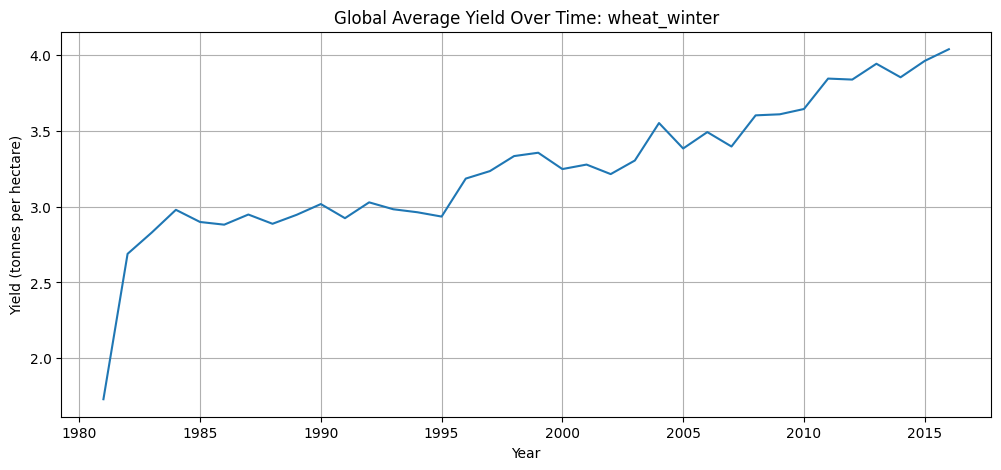

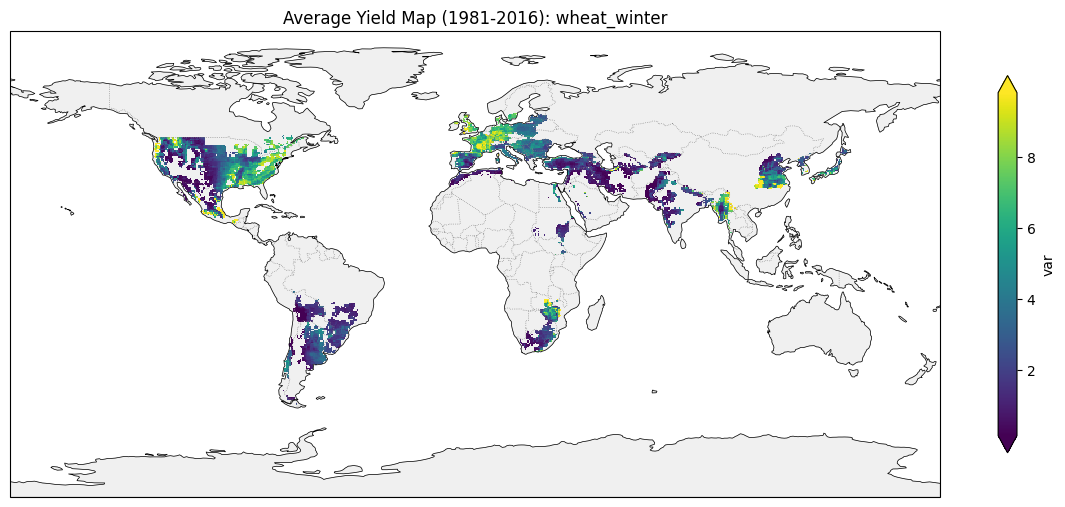

--------------------------------------------------

--- Exploring Dataset: WHEAT_SPRING ---
Dataset loaded successfully.

--- Summary Statistics (tonnes/hectare) ---
mean             3.771441
std              3.784855
min              0.000000
50% (median)     2.554334
max             19.298248
dtype: float64


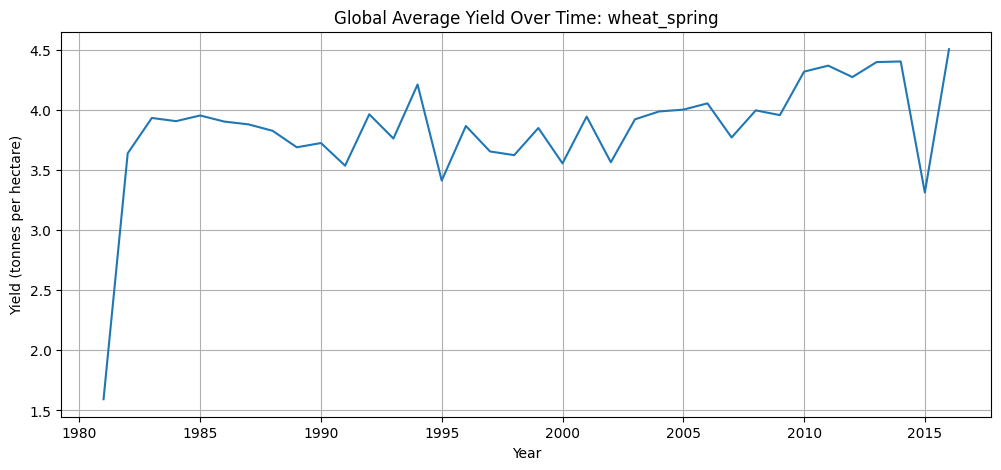

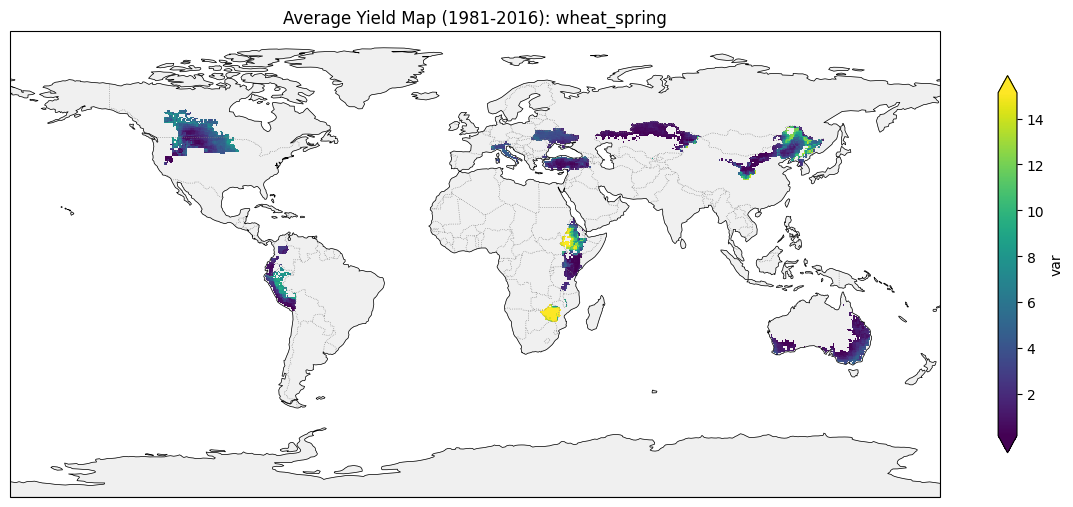

--------------------------------------------------



In [2]:
# Cell 2: Exploring Wheat Varieties
explore_crop_dataset('wheat_winter')
explore_crop_dataset('wheat_spring')

--- Exploring Dataset: RICE ---
Dataset loaded successfully.

--- Summary Statistics (tonnes/hectare) ---
mean             4.254014
std              3.493853
min              0.000000
50% (median)     3.277733
max             25.617229
dtype: float64


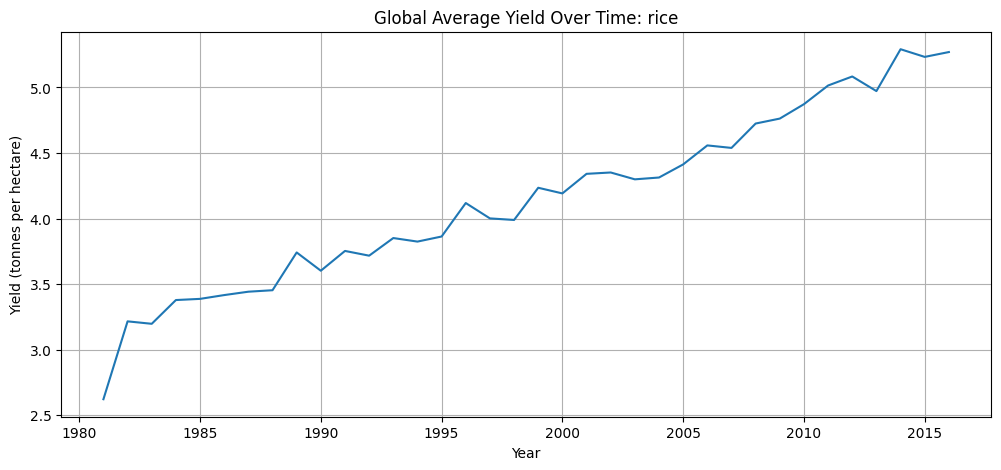

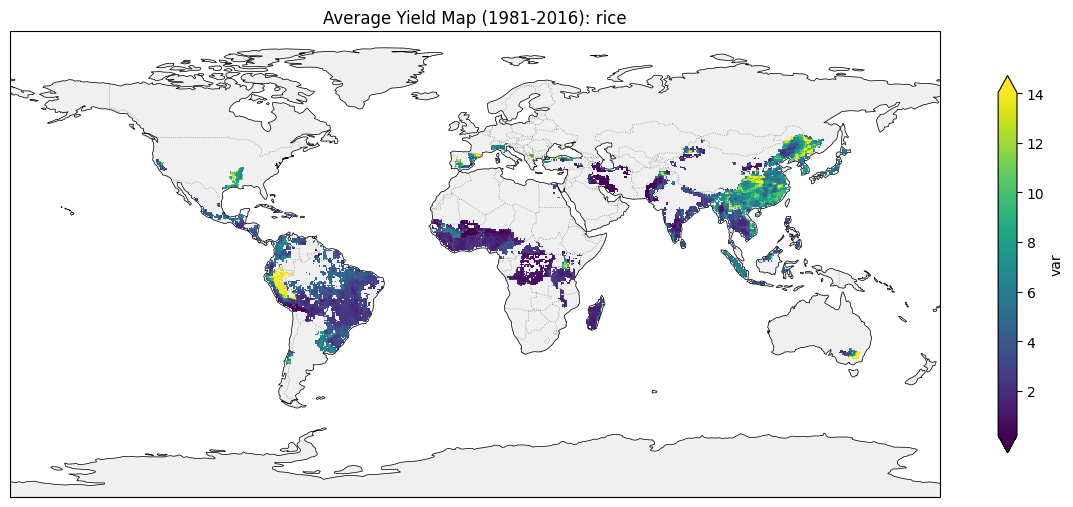

--------------------------------------------------



In [4]:
explore_crop_dataset('rice')